# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!
  

- 🤝 Breakout Room #2:
  1. Creating an Evaluation Dataset
  2. Adding Evaluators
  3. Evaluating

# 🤝 Breakout Room #1

## LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effetively allowing us to recreate appliation flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

In [1]:
%pip install -qU langchain langchain_openai langgraph arxiv duckduckgo-search

Note: you may need to restart the kernel to use updated packages.


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE1 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Duck Duck Go Web Search](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/ddg_search)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

####🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

Answer: `I added DuckDuckGSearchRun and ArxivQueryRun as methods in the following toolbelt:`

In [4]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tool_belt = [
    DuckDuckGoSearchRun(),
    ArxivQueryRun()
]

### Actioning with Tools

Now that we've created our tool belt - we need to create a process that will let us leverage them when we need them.

We'll use the built-in [`ToolExecutor`](https://github.com/langchain-ai/langgraph/blob/main/langgraph/prebuilt/tool_executor.py) to do so.

In [5]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tool_belt)

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [6]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [7]:
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tool_belt]
model = model.bind_functions(functions)

#### ❓ Question #1:

How does the model determine which tool to use?

Answer: `the model determines which tool to use based on the responses` 

## Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [51]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]

## It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [52]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

def call_tool(state):
  last_message = state["messages"][-1]

  action = ToolInvocation(
      tool=last_message.additional_kwargs["function_call"]["name"],
      tool_input=json.loads(
          last_message.additional_kwargs["function_call"]["arguments"]
      )
  )

  response = tool_executor.invoke(action)

  function_message = FunctionMessage(content=str(response), name=action.tool)

  return {"messages" : [function_message]}

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `call_tool` is a node which will call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [53]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

In [54]:
help(StateGraph)

Help on class StateGraph in module langgraph.graph.state:

class StateGraph(langgraph.graph.graph.Graph)
 |  StateGraph(schema: Type[Any]) -> None
 |  
 |  Method resolution order:
 |      StateGraph
 |      langgraph.graph.graph.Graph
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, schema: Type[Any]) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_edge(self, start_key: Union[str, list[str]], end_key: str) -> None
 |  
 |  add_node(self, key: str, action: Union[langchain_core.runnables.base.Runnable[-Input, +Output], Callable[[-Input], +Output], Callable[[-Input], Awaitable[+Output]], Callable[[Iterator[-Input]], Iterator[+Output]], Callable[[AsyncIterator[-Input]], AsyncIterator[+Output]], Mapping[str, Any]]) -> None
 |  
 |  compile(self, checkpointer: Optional[langgraph.checkpoint.base.BaseCheckpointSaver] = None, interrupt_before: Optional[Sequence[str]] = None, interrupt_after: Optional[Sequence[str]] = Non

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [55]:
workflow.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [56]:
def should_continue(state):
  last_message = state["messages"][-1]

  if "function_call" not in last_message.additional_kwargs:
    return "end"

  return "continue"

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : END
    }
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [57]:
workflow.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [58]:
app = workflow.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle? 

Answer: `This particular graph is working like a while loop, so should_continue function here will keep continuing until there's no function call, which in that case it will end/finish. As you see here (in comments):`

```Python
# Define the function that determines whether to continue or not
def should_continue(state):
  last_message = state["messages"][-1]

  # If there is no function call, then we finish
  if "function_call" not in last_message.additional_kwargs:
    return "end"

  # Otherwise if there is, we continue
  return "continue"
```

If not, how could we impose a limit to the number of cycles?

Answer: `we could possibly add a counter to our state that keeps track how many cycles
it has gone through should_continue edge and then put a limit inside should_continue that should end after x amount of cycles `



## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [59]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="What is RAG in the context of Large Language Models? When did it break onto the scene?")]}

app.invoke(inputs)

{'messages': [HumanMessage(content='What is RAG in the context of Large Language Models? When did it break onto the scene?'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"RAG in the context of Large Language Models"}', 'name': 'duckduckgo_search'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 171, 'total_tokens': 196}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'function_call', 'logprobs': None}),
  FunctionMessage(content='Key Takeaways. RAG is a relatively new artificial intelligence technique that can improve the quality of generative AI by allowing large language model (LLMs) to tap additional data resources without retraining. RAG models build knowledge repositories based on the organization\'s own data, and the repositories can be continually updated to ... The beauty of RAG lies in its ability to enable a language model to draw upon and leverage your own data to g

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "function_call" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "function_call" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [60]:
inputs = {"messages" : [HumanMessage(content="What is QLoRA in Machine Learning? Are their any papers that could help me understand? Once you have that information, can you look up the bio of the first author on the QLoRA paper?")]}

app.invoke(inputs)

{'messages': [HumanMessage(content='What is QLoRA in Machine Learning? Are their any papers that could help me understand? Once you have that information, can you look up the bio of the first author on the QLoRA paper?'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"QLoRA in Machine Learning"}', 'name': 'duckduckgo_search'}}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 193, 'total_tokens': 215}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'function_call', 'logprobs': None}),
  FunctionMessage(content="Our results show that QLoRA finetuning on a small high-quality dataset leads to state-of-the-art results, even when using smaller models than the previous SoTA. We provide a detailed analysis of chatbot performance based on both human and GPT-4 evaluations showing that GPT-4 evaluations are a cheap and reasonable alternative to human evaluation. Balancing this tradeoff is a 

####🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

Answer:

1) First step is that the agent decides what action it should to take 
2) if the agent decides to continue by doing an action then it will call the function call_tool
3) In call_tool we construct a ToolInvocation where we pass in the name of the tool and pass in as json arguments. In this case it is  the query and the name of the tool.
4) next we invoke the tool_executor and we pass in our ToolInvocation we made in part 3 that contains information on howto invoke a tool.
5) the Response from tool execture in part 4 is what pass in as response to a FunctionMessage together with the name of the tool we invoked
6) we then return a list because it will be added to the existing list. 

`The parts can also be seen in the code here:`

```Python
# Define the function to execute tools
def call_tool(state):

# Based on the continue condition
# we know the last message involves a function call
  last_message = state["messages"][-1]

# part 3 - We construct an ToolInvocation from the function_call
  action = ToolInvocation(
      tool=last_message.additional_kwargs["function_call"]["name"],
      tool_input=json.loads(
          last_message.additional_kwargs["function_call"]["arguments"]
      )
  )

# part 4 - We call the tool_executor and get back a response
  response = tool_executor.invoke(action)

# part 5 - We use the response to create a FunctionMessage

  function_message = FunctionMessage(content=str(response), name=action.tool)

# part 6 - We return a list, because this will get added to the existing list
  return {"messages" : [function_message]}

```

here an example of an output

1) first thing graph does is doing a function call to the tool duckduckgo with query "QLoRA in Machine Learning" and gets a respons back
2) it then loops through the graph does again a function call now using the tool arxiv with the query "QLoRA in Machine Learning" and gets a respons back
3) it then does a function call with tool duckduckgo now using the query "Tim Dettmers bio" and gets a respons back
4) it then finally responds back the finally answer.


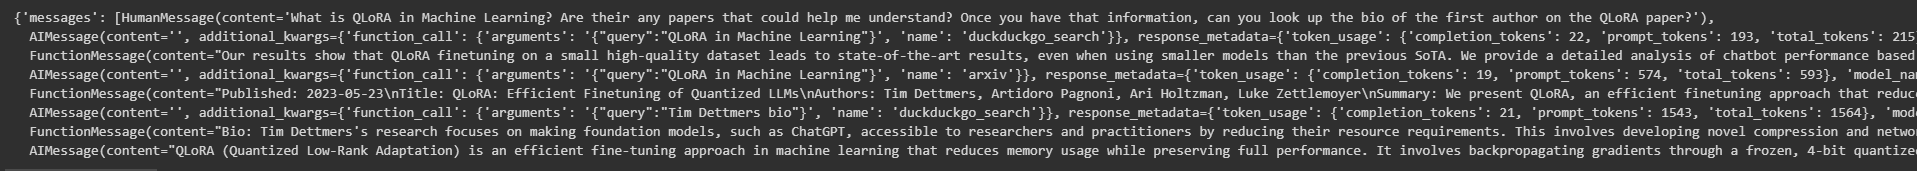



### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [ ]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain = convert_inputs | app | parse_output

In [62]:
agent_chain.invoke({"question" : "What is RAG?"})

"RAG stands for Retrieval-Augmented Generation. It is an AI framework that improves the quality of Large Language Models (LLMs) generated responses by grounding the model on external sources of knowledge to supplement the LLM's internal representation of information. RAG is used to enhance generative AI models with facts from external sources, ensuring that the model has access to the most current and reliable information."

# 🤝 Breakout Room #2

## Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

####🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [63]:
questions = [
    ### YOUR QUESTIONS HERE
    "Who authored attention is all your need paper?",
    "What is self-attention?",
    "What is quantization?",
    "What is low-rank adaptation of large language models?",
    "what is semantic search?",
    "what is Recurrent neural networks?"
]


answers = [
    ### YOUR ANSWERS HERE
    {"must_mention" : ["Ashish","Noam", "Niki", "jakob", "Llion","Aidan", "Kaiser"]},
    {"must_mention" : ["self-attention","intra-attention"]},
    {"must_mention" : ["quantization", "large language models"]},
    {"must_mention" : ["weights", "LoRA"]},
    {"must_mention" : ["semantic search"]},
    {"must_mention" : ["RNN","Recurrent neural networks"]},
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [64]:
from langsmith import Client

client = Client()
dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

#### ❓ Question #3:

How are the correct answers associated with the questions?

Answer: `I figured out that's very important to specify keywords that are close to the answer you want to get back or else it will hallucinate - forexample if I don't give quantization specific keywords related to large language models it will hallucinate by answering by giving back a physics answer. It could be problematic in case of getting relevant answers back. But I can also give to many keywords, and it might not return back an answer like in question who's the authors of attention is all your need and provide too many different authors as keywords.`

`An example of hallutination on the question on quantization plus an example of providing too many keywords to the question of who is authors of the paper attention is all your need:`

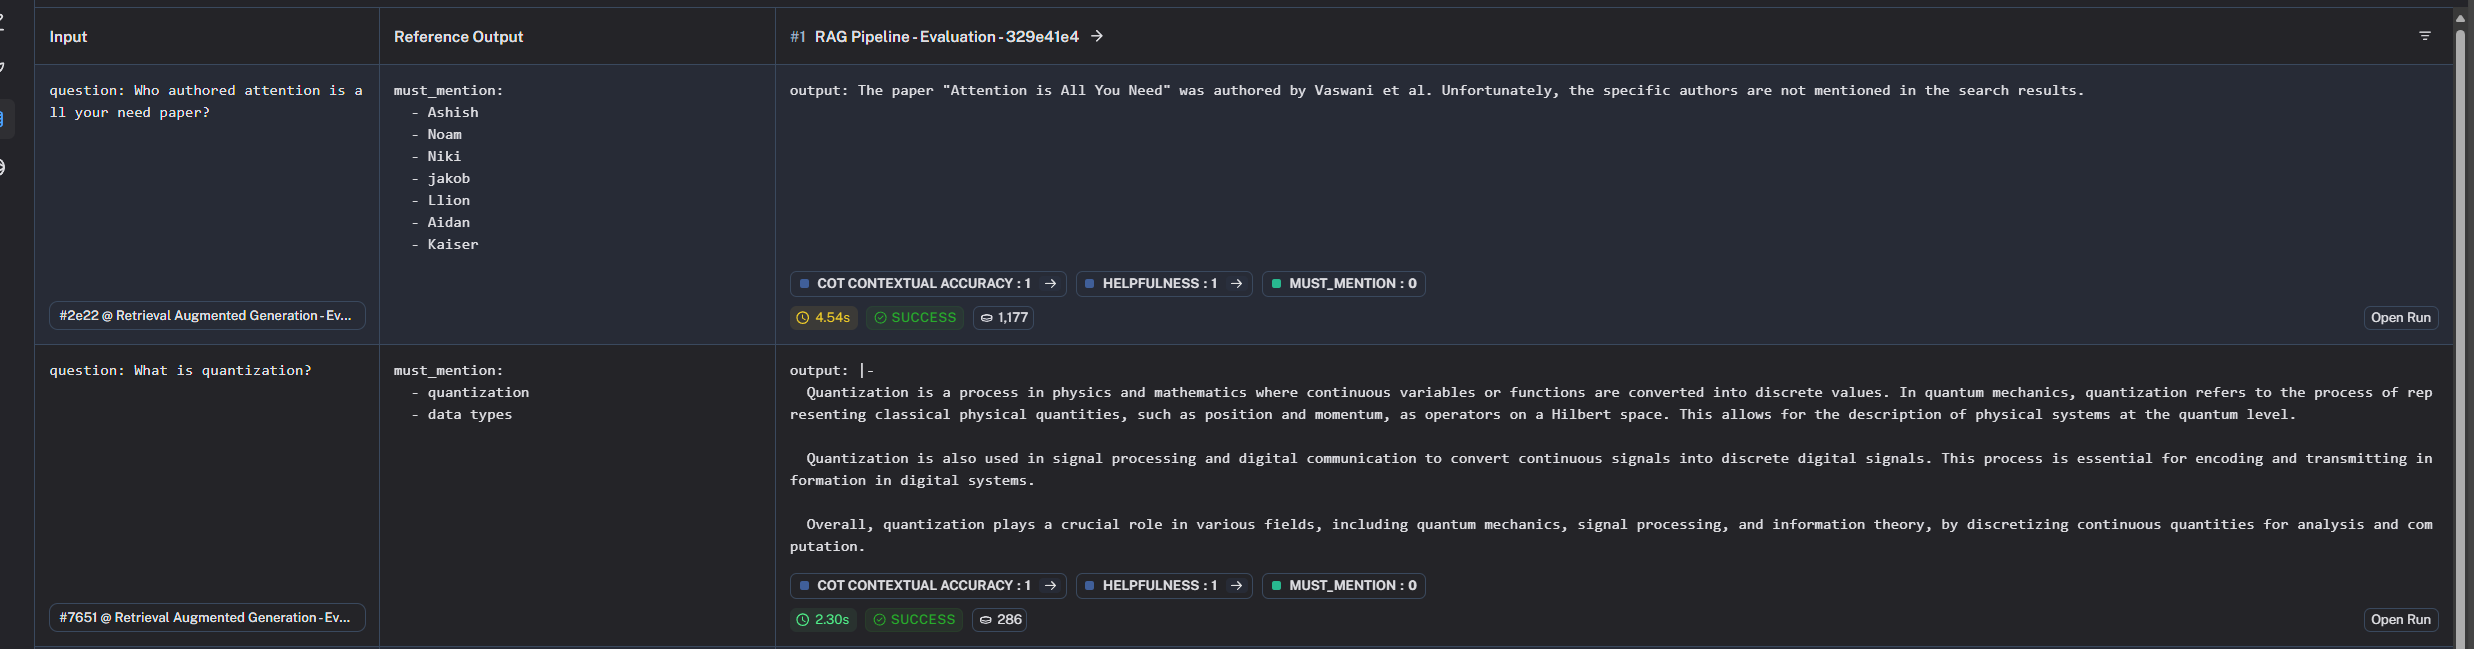


> NOTE: Feel free to indicate if this is problematic or not





## Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [65]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

So here I will use some part from the nlp preprocessing.

1) remove stop words - remove common words we don't need - NTLK library can help us out here, but we can start with expressions like .!,",#,$ etc.
2) lower case words - so we don't have to handle cases of case sensitivity.
3) stemming - extract the root form of the word
      for example:
      * if the word ends in "ed" we remove "ed"
      * if the word ends in "ing" we remove "ing"
4) lemmatization - returns the dictionary meaning of the word after a word is converted into a root form (using stemming)

```Python

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

```


> NOTE: Alternatively you can suggest where gaps exist in this method.

Now that we have created our custom evaluator - let's initialize our `RunEvalConfig` with it, and a few others:

- `"criteria"` includes the default criteria which, in this case, means "helpfulness"
- `"cot_qa"` includes a criteria that bases whether or not the answer is correct by utilizing a Chain of Thought prompt and the provided context to determine if the response is correct or not.

In [66]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[must_mention],
    evaluators=[
        "criteria",
        "cot_qa",
    ],
)

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [67]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=agent_chain,
    evaluation=eval_config,
    verbose=True,
    project_name=f"RAG Pipeline - Evaluation - {uuid4().hex[0:8]}",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'RAG Pipeline - Evaluation - 329e41e4' at:
https://smith.langchain.com/o/269156a3-d252-5d5c-9e5a-09f79ff84f0a/datasets/7027abbe-374c-48bf-b349-797d3a7e07e2/compare?selectedSessions=8669b53c-264e-4bc4-9ab3-ad07d12d8b97

View all tests for Dataset Retrieval Augmented Generation - Evaluation Dataset - 90808643 at:
https://smith.langchain.com/o/269156a3-d252-5d5c-9e5a-09f79ff84f0a/datasets/7027abbe-374c-48bf-b349-797d3a7e07e2
[------------------------------------------------->] 6/6

,feedback.helpfulness,feedback.COT Contextual Accuracy,feedback.must_mention,error,execution_time,run_id
count,6.0,6.0,6,0,6.000000,6
unique,NaN,NaN,2,0,NaN,6
top,NaN,NaN,False,NaN,NaN,2f55e8ab-4411-430e-9d18-2d604733f1ee
freq,NaN,NaN,4,NaN,NaN,1
mean,1.0,1.0,NaN,NaN,4.235819,NaN
std,0.0,0.0,NaN,NaN,1.496013,NaN
min,1.0,1.0,NaN,NaN,2.298210,NaN
25%,1.0,1.0,NaN,NaN,3.413779,NaN
50%,1.0,1.0,NaN,NaN,4.215423,NaN
75%,1.0,1.0,NaN,NaN,4.693787,NaN


{'project_name': 'RAG Pipeline - Evaluation - 329e41e4',
 'results': {'2e220f0c-d29c-42af-880f-b897ced04f52': {'input': {'question': 'Who authored attention is all your need paper?'},
   'feedback': [EvaluationResult(key='helpfulness', score=1, value='Y', comment='The criterion for this task is "helpfulness". The submission should be helpful, insightful, and appropriate. \n\nLooking at the submission, it does provide an answer to the input question. The input asks who authored the paper "Attention is All You Need". The submission correctly states that the paper was authored by Vaswani et al. \n\nHowever, the submission also includes a statement that the specific authors are not mentioned in the search results. This is not necessary information and could potentially confuse the person asking the question. \n\nDespite this, the submission does provide the correct authorship for the paper, which is the main point of the question. Therefore, it can be considered helpful and appropriate. \n